In [435]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [436]:
##Reading train and test 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

In [437]:
test["amount_spent_per_room_night_scaled"] = 7
train["data"] = "train"
test["data"] = "test"

In [438]:
all1 = pd.concat([train,test] , axis=0)

In [439]:
alldata = all1.copy()

In [440]:
alldata["booking_date"] = pd.to_datetime(alldata["booking_date"] , format="%d/%m/%y")
alldata["checkin_date"] = pd.to_datetime(alldata["checkin_date"] , format="%d/%m/%y")
alldata["checkout_date"] = pd.to_datetime(alldata["checkout_date"] , format="%d/%m/%y")

In [441]:
checkins = alldata.groupby(["resort_id","checkin_date"])["checkin_date"].count().reset_index(name="checkin_count")
checkouts = alldata.groupby(["resort_id","checkout_date"])["checkout_date"].count().reset_index(name="checkout_count")
checkouts.columns = ["resort_id","checkin_date","checkout_count"]
first_visit_date = alldata.groupby("memberid")["checkin_date"].min().reset_index(name="first_visit_date")

In [442]:
alldata = pd.merge(left=alldata,right=checkins,how="left",on=["resort_id","checkin_date"])
alldata = pd.merge(left=alldata,right=checkouts,how="left",on=["resort_id","checkin_date"])
alldata = pd.merge(left=alldata,right=first_visit_date,how="left",on=["memberid"])
#alldata = pd.merge(left=alldata,right=temp,how="left",on=["resort_id","checkin_date"])

In [443]:
alldata.columns

Index(['reservation_id', 'booking_date', 'checkin_date', 'checkout_date',
       'channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled', 'data', 'checkin_count',
       'checkout_count', 'first_visit_date'],
      dtype='object')

In [444]:
alldata["days_before_checkin"] = (alldata["checkin_date"] - alldata["booking_date"]).dt.days
alldata["days_since_first_visit"] = (alldata["checkin_date"] - alldata["first_visit_date"]).dt.days
alldata["Room_Nights_Per_Head"] = alldata["roomnights"]/(alldata["numberofadults"]+alldata["numberofchildren"])
alldata["checkin_year"] = alldata["checkin_date"].dt.year
alldata["checkin_weekday"] = alldata["checkin_date"].dt.weekday
alldata["weekend_checkin_flag"] = np.where(alldata["checkin_weekday"] >=5,1,0)
alldata["checkin_month"] = alldata["checkin_date"].dt.month
alldata["checkin_monthday"] = alldata["checkin_date"].dt.day
alldata["checkin_week_year"] = alldata["checkin_date"].dt.week
alldata["booking_month"] = alldata["booking_date"].dt.month
alldata["booking_weekday"] = alldata["booking_date"].dt.weekday
alldata["booking_monthday"] = alldata["booking_date"].dt.day
alldata["checkout_weekday"] = alldata["checkout_date"].dt.weekday

In [445]:
alldata["Visits_Before"] = alldata.groupby("memberid")["checkin_date"].rank(ascending=True) - 1
alldata.sort_values(by = ["memberid" , "checkin_date"] , ascending=[True , True] , inplace=True)
alldata["Days_Since_Last_Visit"] = (alldata["checkin_date"] - alldata.groupby("memberid")["checkin_date"].shift(1)).dt.days
alldata["Days_Since_Last_Visit"] = np.where(alldata["Days_Since_Last_Visit"].isnull() , -1 , alldata["Days_Since_Last_Visit"])

In [446]:
##Creating features - roomnights consumed in a year so far by a member
##Total roomnights consumed so far
alldata["roomnights_this_year_cumsum"]=alldata.groupby(["memberid","checkin_year"])['roomnights'].cumsum()
alldata["roomnights_cumsum"]=alldata.groupby(["memberid"])['roomnights'].cumsum()
alldata["resort_level_rank_by_roomnights"] = alldata.groupby(["resort_id","checkin_date"])['roomnights'].rank(ascending=False)

In [448]:
alldata["Resort_Same_As_Last_One"] = (alldata["resort_id"] == alldata.groupby("memberid")["resort_id"].shift(1))*1
alldata["state_code_residence"] = np.where(alldata["state_code_residence"].isnull(),100,alldata["state_code_residence"])
alldata["state_code_resort"] = np.where(alldata["state_code_resort"].isnull(),100,alldata["state_code_resort"])
alldata["Residence_to_resort"] = alldata["state_code_residence"].astype(str) + "_" + alldata["state_code_resort"].astype(str)

In [449]:
alldata.columns

Index(['reservation_id', 'booking_date', 'checkin_date', 'checkout_date',
       'channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled', 'data', 'checkin_count',
       'checkout_count', 'first_visit_date', 'days_before_checkin',
       'days_since_first_visit', 'Room_Nights_Per_Head', 'checkin_year',
       'checkin_weekday', 'weekend_checkin_flag', 'checkin_month',
       'checkin_monthday', 'checkin_week_year', 'booking_month',
       'booking_weekday', 'booking_monthday', 'checkout_weekday',
       'Visits_Before', 'Days_Since_Last_Visit', 'roomnights_this_year_cumsum',
       'roomnights_cum

In [450]:
###Getting Count Vars
def getCount(data,column,target):
    
    group = data.groupby(column)[target].agg(["count"])
    group = group.to_dict()['count']
    
    new_var = column+"_"+"count_var"
    data[new_var] = data[column]
    data[new_var] = data[new_var].map(group)

def getTargetMean(data,column,target):
    
    group = data[data["data"]=="train"].groupby(column)[target].agg(["mean"])
    group = group.to_dict()['mean']
    
    new_var = column+"_"+"mean_encoding_var"
    data[new_var] = data[column]
    data[new_var] = data[new_var].map(group)

In [451]:
getCount(data=alldata,column="resort_id",target="amount_spent_per_room_night_scaled")
getTargetMean(data=alldata,column="resort_id",target="amount_spent_per_room_night_scaled")
getCount(data=alldata,column="member_age_buckets",target="amount_spent_per_room_night_scaled")
getTargetMean(data=alldata,column="member_age_buckets",target="amount_spent_per_room_night_scaled")
getCount(data=alldata,column="Residence_to_resort",target="amount_spent_per_room_night_scaled")
getTargetMean(data=alldata,column="Residence_to_resort",target="amount_spent_per_room_night_scaled")

In [452]:
cat_vars = ["channel_code" , "main_product_code" , "persontravellingid" , "resort_region_code" , "resort_type_code"
           ,"room_type_booked_code" , "season_holidayed_code" , "state_code_residence" , "state_code_resort"
           ,"cluster_code" , "reservationstatusid_code","member_age_buckets"]

In [453]:
alldata = pd.get_dummies(alldata,dummy_na=True,columns = cat_vars,dtype="int") 

In [454]:
lb = LabelEncoder()
alldata["resort_id"] = lb.fit_transform(alldata["resort_id"])
alldata["Residence_to_resort"] = lb.fit_transform(alldata["Residence_to_resort"])

In [455]:
tr = alldata[alldata["data"] == "train"]
ts = alldata[alldata["data"] == "test"]

X_train = tr.drop(["reservation_id","booking_date","checkin_date","checkout_date","memberid","data","first_visit_date"
                  ,"amount_spent_per_room_night_scaled"],axis=1)
Y_train = tr.amount_spent_per_room_night_scaled.values

X_test = ts.drop(["booking_date","checkin_date","checkout_date","memberid","data","first_visit_date"
                  ,"amount_spent_per_room_night_scaled"]
        ,axis=1)

In [457]:
len(X_train.columns) , len(X_test.columns)

(155, 156)

In [279]:
params = {'colsample_bytree': 0.7,'subsample':0.8,'learning_rate': 0.1,'max_depth': 5}

cv_results = xgb.cv(dtrain=xgb.DMatrix(data = X_train , label = Y_train), params=params, nfold=3
                    ,num_boost_round=500,early_stopping_rounds=50,metrics="rmse",as_pandas=True
                    , seed=123 ,verbose_eval=50)

[0]	train-rmse:6.58826+0.000481338	test-rmse:6.58822+0.00144898
[50]	train-rmse:1.0039+0.00140075	test-rmse:1.00928+0.00405423
[100]	train-rmse:0.982397+0.00324216	test-rmse:0.992685+0.00371888
[150]	train-rmse:0.971407+0.00268447	test-rmse:0.986004+0.00273211
[200]	train-rmse:0.963189+0.00246652	test-rmse:0.981851+0.00302812
[250]	train-rmse:0.955551+0.00214765	test-rmse:0.978576+0.00304557
[300]	train-rmse:0.949496+0.0019894	test-rmse:0.976377+0.00323138
[350]	train-rmse:0.944869+0.00186257	test-rmse:0.975729+0.00326639
[400]	train-rmse:0.940706+0.00194792	test-rmse:0.975338+0.00309226
[450]	train-rmse:0.936708+0.00196992	test-rmse:0.975009+0.00305903
[499]	train-rmse:0.93321+0.00191724	test-rmse:0.975031+0.0031558


In [458]:
#setting parameters for xgboost
parameters={'max_depth':5, 'silent':1,'eval_metric':'rmse'
            ,'learning_rate':.1, 'colsample_bytree' : 0.7,'seed':123}
num_round=600

In [459]:
dtrain=xgb.DMatrix(data = X_train,label = Y_train)

In [460]:
#training our model 
xgb_model=xgb.train(parameters,dtrain,num_round)

In [461]:
xgb_train = xgb_model.predict(dtrain)

In [462]:
rmse = np.sqrt(mean_squared_error(y_true = Y_train , y_pred = xgb_train)) 

In [463]:
rmse

0.9361655225293107

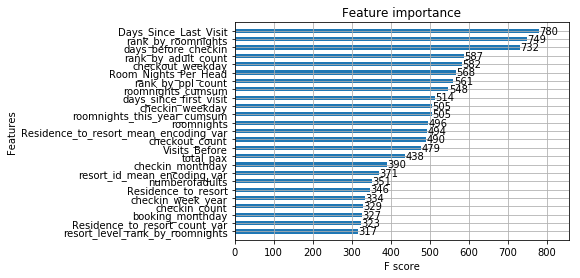

In [464]:
xgb.plot_importance(xgb_model,height=0.5,max_num_features=25)

In [465]:
test_Pk = X_test.reservation_id
dtest = xgb.DMatrix(X_test.drop(["reservation_id"],axis=1)) 

In [466]:
y_test = xgb_model.predict(dtest)

In [467]:
sub = pd.DataFrame({'reservation_id':test_Pk , 'amount_spent_per_room_night_scaled':y_test})
sub.to_csv('xgb_8.csv',index=None)